# 第5章 决策树¶

1．分类决策树模型是表示基于特征对实例进行分类的树形结构。决策树可以转换成一个if-then规则的集合，也可以看作是定义在特征空间划分上的类的条件概率分布。

2．决策树学习旨在构建一个与训练数据拟合很好，并且复杂度小的决策树。因为从可能的决策树中直接选取最优决策树是NP完全问题。现实中采用启发式方法学习次优的决策树。

决策树学习算法包括3部分：特征选择、树的生成和树的剪枝。常用的算法有ID3、 C4.5和CART。

3．特征选择的目的在于选取对训练数据能够分类的特征。特征选择的关键是其准则。常用的准则如下：

（1）样本集合$D$对特征$A$的信息增益（ID3）

$$g(D, A)=H(D)-H(D|A)$$$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$
其中，$H(D)$是数据集$D$的熵，$H(D_i)$是数据集$D_i$的熵，$H(D|A)$是数据集$D$对特征$A$的条件熵。 $D_i$是$D$中特征$A$取第$i$个值的样本子集，$C_k$是$D$中属于第$k$类的样本子集。$n$是特征$A$取 值的个数，$K$是类的个数。

（2）样本集合$D$对特征$A$的信息增益比（C4.5）

$$g_{R}(D, A)=\frac{g(D, A)}{H(D)}$$
其中，$g(D,A)$是信息增益，$H(D)$是数据集$D$的熵。

（3）样本集合$D$的基尼指数（CART）

$$\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2}$$
特征$A$条件下集合$D$的基尼指数：

$$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}\left(D_{1}\right)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}\left(D_{2}\right)$$

4．决策树的生成。通常使用信息增益最大、信息增益比最大或基尼指数最小作为特征选择的准则。决策树的生成往往通过计算信息增益或其他指标，从根结点开始，递归地产生决策树。这相当于用信息增益或其他准则不断地选取局部最优的特征，或将训练集分割为能够基本正确分类的子集。

5．决策树的剪枝。由于生成的决策树存在过拟合问题，需要对它进行剪枝，以简化学到的决策树。决策树的剪枝，往往从已生成的树上剪掉一些叶结点或叶结点以上的子树，并将其父结点或根结点作为新的叶结点，从而简化生成的决策树。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from math import log
import pprint

## 书上的题目5.1

In [ ]:
#书上的题目5.1
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    return datasets, labels

In [ ]:
datasets, labels = create_data()

In [ ]:
train_data = pd.DataFrame(datasets, columns=labels)

In [ ]:
train_data

In [ ]:
#经验熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p / data_length) * log(p / data_length, 2)
               for p in label_count.values()])
    return ent

#经验条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum([(len(p) / data_length) * calc_ent(p) 
                   for p in feature_sets.values()])
    return cond_ent

#信息增益
def info_gain(ent, cond_ent):
    return ent-cond_ent

def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
        #比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增熵最大，选择为根节点特征'.format(labels[best_[0]])

In [ ]:
info_gain_train(np.array(datasets))

利用ID3算法生成决策树，例5.3

In [ ]:
#定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {
            'label': self.label,
            'feature': self.feature,
            'tree': self.tree
        }
        
    def __repr__(self):
        return '{}'.format(self.result)
    
    def add_node(self, val, node):
        self.tree[val] = node
    
    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)

class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p / data_length) * log(p / data_length, 2)
                    for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p) / data_length) * self.calc_ent(p)
                        for p in feature_sets.values()])
        return cond_ent
    
    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :
                                               -1], train_data.iloc[:,
                                                                    -1], train_data.columns[:
                                                                                            -1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True, label=y_train.iloc[0])

        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])
        
        # 5,构建Ag子集
        node_tree = Node(
            root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] ==
                                          f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        # pprint.pprint(node_tree.tree)
        return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

In [ ]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

In [ ]:
tree

In [ ]:
dt.predict(['老年', '否', '否', '一般'])

### scikit-learn实例

In [2]:
#data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = [
        'sepal length', 'sepal width', 'petal length', 'petal width', 'label'
    ]
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:, :2], data[:, -1]


X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [5]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [6]:
clf.score(X_test, y_test)

0.9333333333333333

In [7]:
tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()

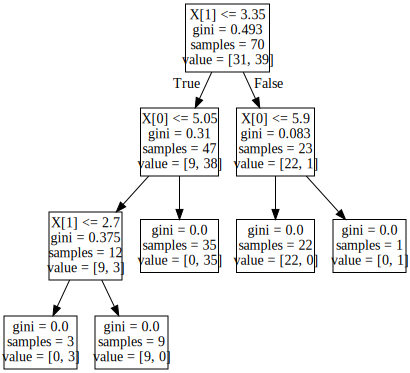

In [8]:
graphviz.Source(dot_graph)